### Import 

In [95]:
import requests
from lxml import html
import json
import pandas as pd
from pandas.api.types import is_string_dtype,is_numeric_dtype
import numpy as np
import os
from bs4 import BeautifulSoup
import re
import smtplib
from email.message import EmailMessage
from email.mime.text import MIMEText
from email.mime.application import MIMEApplication
from email.mime.multipart import MIMEMultipart
import csv
from datetime import date
from plotly.offline import plot
import plotly.graph_objects as go
import math
import warnings

from fastai.imports import *
from fastai.tabular import *
from fastai.tabular.core import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor
from IPython.display import display

from sklearn import metrics

import IPython, graphviz
from sklearn.tree import export_graphviz

%config IPCompleter.greedy=True

In [96]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth',1000)
warnings.filterwarnings("ignore")

### Configuration

In [97]:
pointSystem = {
        'total_runs': 1,
        'run_6': 2,
        'run_4': 1,
        '>=50': 8,
        '>=100': 16,
        'duck': -2,
        'total_wickets': 25,
        '>=4W': 8,
        '>=5W': 16,
        'maiden_overs': 8,
        '<=4E': 6,
        '<5E': 4,
        '<6E': 2,
        '>9E': -2,
        '>10E': -4,
        '>11E': -6
    }

In [98]:
teamConstraints = {'MAXCOSTPOINT': 100,
                   'MINBATSMEN': 3,
                   'MAXBATSMEN': 7,
                   'MINBOWLER': 3,
                   'MAXBOWLER': 6,
                   'MINALLROUNDER': 1,
                   'MAXALLROUNDER': 4,
                   'MAXPLAYERCOUNT': 11,
                   'MAXTEAMCOUNT': 7}

In [99]:
 colconfig = {'MATCHID': 'match_id',
             'BATSMANNAME': 'batsmanname',
             'BOWLERNAME': 'bowlername',
             'SCOREVALUE': 'scorevalue',
             'OVER': 'over',
             'INNINGS': 'innings',
             'VENUE': 'venue',
             'TOTALBALLSBOWLED': 'total_balls_bowled',
             'BATTINGORDER': 'fallofwickets',
             'BATTINGTEAM': 'battingteam',
             'BOWLINGTEAM': 'bowlingteam',
             'PLAYERNAME': 'playername',
             'TOTALBATPOINTS': 'total_bat_points',
             'TOTALBALLPOINTS': 'total_bowl_points',
             'ACTUALPOINTS': 'total_points',
             'PREDPOINTS': 'pred_points',
             'PLAYERTEAM':'playing_team',
             'PLAYERCOST': 'playercost',
             'PLAYINGROLE': 'playing_role',
             'PREDSELECTION': 'pred_selection_true',
             'ACTUALSELECTION': 'actual_selection_true',
             'PREDSELECTIONRANK': 'pred_selection_rank',
             'ACTUALSELECTIONRANK': 'actual_selection_rank'}

### Fetch Raw Data

In [300]:
df_raw = pd.read_csv("C:/Users/SinhAp01/New_Projects/Training/IPL/Files/all_matches.csv")
df_name = pd.read_csv("C:/Users/SinhAp01/New_Projects/Training/IPL/Files/name_mapping.csv")
df_squads = pd.read_csv("C:/Users/SinhAp01/New_Projects/Training/IPL/Files/Squads_2021.csv")
df_toss = pd.read_csv("C:/Users/SinhAp01/New_Projects/Training/IPL/Files/IPL_Toss_Data.csv")
#df_playerprofile = pd.read_csv("C:/Users/SinhAp01/New_Projects/Training/IPL/Files/cricket_data.csv")
df_personal_male = pd.read_csv("C:/Users/SinhAp01/New_Projects/Training/IPL/Files/personal_male.csv")

# Join df_toss with df_raw
df_raw = df_raw.join(df_toss.set_index('match_id'), on='match_id')

### Data Clean

##### Clean Stadium Names

In [301]:
for df in [df_raw]:
    df = df.replace(to_replace ="Wankhede Stadium",value ="Wankhede Stadium, Mumbai")
    df = df.replace(to_replace ="M Chinnaswamy Stadium",value ="M.Chinnaswamy Stadium, Bengaluru")
    df = df.replace(to_replace ="M.Chinnaswamy Stadium",value ="M.Chinnaswamy Stadium, Bengaluru")
    df = df.replace(to_replace ="MA Chidambaram Stadium",value ="MA Chidambaram Stadium, Chepauk, Chennai")
    df = df.replace(to_replace ="MA Chidambaram Stadium, Chepauk",value ="MA Chidambaram Stadium, Chepauk, Chennai")
    df = df.replace(to_replace ="Eden Gardens",value ="Eden Gardens, Kolkata")
    df = df.replace(to_replace ="Feroz Shah Kotla",value ="Arun Jaitley Stadium, Delhi")

##### Clean Player Names

In [302]:
for player in df_name.FullName:
    sn = df_name[df_name['FullName'] == player]['ShortName']
    df_raw = df_raw.replace(to_replace = sn.values[0],value = player)
    
#CSK
df_raw = df_raw.replace(to_replace ="RD Gaikwad",value ="Ruturaj Gaikwad")
df_raw = df_raw.replace(to_replace ="F du Plessis",value ="Faf du Plessis")
df_raw = df_raw.replace(to_replace ="MM Ali",value ="Moeen Ali")
df_raw = df_raw.replace(to_replace ="SK Raina",value ="Suresh Raina")
df_raw = df_raw.replace(to_replace ="AT Rayudu",value ="Ambati Rayudu")
df_raw = df_raw.replace(to_replace ="SM Curran",value ="Sam Curran")
df_raw = df_raw.replace(to_replace ="RA Jadeja",value ="Ravindra Jadeja")
df_raw = df_raw.replace(to_replace ="DJ Bravo",value ="Dwayne Bravo")
df_raw = df_raw.replace(to_replace ="SN Thakur",value ="Shardul Thakur")
df_raw = df_raw.replace(to_replace ="DL Chahar",value ="Deepak Chahar")

#PBKS
df_raw = df_raw.replace(to_replace ="MA Agarwal",value ="Mayank Agarwal")
df_raw = df_raw.replace(to_replace ="CH Gayle",value ="Chris Gayle")
df_raw = df_raw.replace(to_replace ="DJ Hooda",value ="Deepak Hooda")
df_raw = df_raw.replace(to_replace ="N Pooran",value ="Nicholas Pooran")
df_raw = df_raw.replace(to_replace ="M Shahrukh Khan",value ="Shahrukh Khan")
df_raw = df_raw.replace(to_replace ="JA Richardson",value ="Jhye Richardson")
df_raw = df_raw.replace(to_replace ="M Ashwin",value ="Murugan Ashwin")

#SRH
df_raw = df_raw.replace(to_replace ="DA Warner",value ="David Warner")
df_raw = df_raw.replace(to_replace ="KK Ahmed",value ="Khaleel Ahmed")
df_raw = df_raw.replace(to_replace ="JM Bairstow",value ="Jonny Bairstow")
df_raw = df_raw.replace(to_replace ="DA Warner",value ="Basil Thampi")
df_raw = df_raw.replace(to_replace ="PK Garg",value ="Priyam Garg")
df_raw = df_raw.replace(to_replace ="SP Goswami",value ="Shreevats Goswami")
df_raw = df_raw.replace(to_replace ="JO Holder",value ="Jason Holder")
df_raw = df_raw.replace(to_replace ="KM Jadhav",value ="Kedar Jadhav")
df_raw = df_raw.replace(to_replace ="S Kaul",value ="Siddarth Kaul")
df_raw = df_raw.replace(to_replace ="B Kumar",value ="Bhuvneshwar Kumar")
df_raw = df_raw.replace(to_replace ="S Nadeem ",value ="Shahbaz Nadeem")
df_raw = df_raw.replace(to_replace ="MK Pandey",value ="Manish Pandey")
df_raw = df_raw.replace(to_replace ="JJ Roy",value ="Jason Roy")
df_raw = df_raw.replace(to_replace ="WP Saha",value ="Wriddhiman Saha")
df_raw = df_raw.replace(to_replace ="V Shankar",value ="Vijay Shankar")
df_raw = df_raw.replace(to_replace ="J Suchith",value ="Jagadeesha Suchith")
df_raw = df_raw.replace(to_replace ="KS Williamson",value ="Kane Williamson")

#MI
df_raw = df_raw.replace(to_replace ="RG Sharma",value ="Rohit Sharma")
df_raw = df_raw.replace(to_replace ="A Singh",value ="Anmolpreet Singh")
df_raw = df_raw.replace(to_replace ="TA Boult",value ="Trent Boult")
df_raw = df_raw.replace(to_replace ="JJ Bumrah",value ="Jasprit Bumrah")
df_raw = df_raw.replace(to_replace ="RD Chahar",value ="Rahul Chahar")
df_raw = df_raw.replace(to_replace ="PP Chawla",value ="Piyush Chawla")
df_raw = df_raw.replace(to_replace ="NM Coulter-Nile",value ="Nathan Coulter-Nile")
df_raw = df_raw.replace(to_replace ="Q de Kock",value ="Quinton de Kock")
df_raw = df_raw.replace(to_replace ="Ishan Kishan",value ="Ishan Kishan")
df_raw = df_raw.replace(to_replace ="M Jansen",value ="Marco Jansen")
df_raw = df_raw.replace(to_replace ="DS Kulkarni",value ="Dhawal Kulkarni")
df_raw = df_raw.replace(to_replace ="CA Lynn",value ="Chris Lynn")
df_raw = df_raw.replace(to_replace ="AF Milne",value ="Adam Milne")
df_raw = df_raw.replace(to_replace ="JDS Neesham",value ="James Neesham")
df_raw = df_raw.replace(to_replace ="KH Pandya",value ="Krunal Pandya")
df_raw = df_raw.replace(to_replace ="HH Pandya",value ="Hardik Pandya")
df_raw = df_raw.replace(to_replace ="KA Pollard",value ="Kieron Pollard")
df_raw = df_raw.replace(to_replace ="AP Tare",value ="Aditya Tare")
df_raw = df_raw.replace(to_replace ="SS Tiwary",value ="Saurabh Tiwary")
df_raw = df_raw.replace(to_replace ="J Yadav",value ="Jayant Yadav")
df_raw = df_raw.replace(to_replace ="SA Yadav",value ="Suryakumar Yadav")

##### Clean Team Names

In [303]:
df_raw = df_raw.replace(to_replace ="Kings XI Punjab",value ="Punjab Kings")
df_raw = df_raw.replace(to_replace ="Rising Pune Supergiants",value ="Pune Warriors")
df_raw = df_raw.replace(to_replace ="Rising Pune Supergiant",value ="Pune Warriors")
df_raw = df_raw.replace(to_replace ="Deccan Chargers",value ="Sunrisers Hyderabad")
df_raw = df_raw.replace(to_replace ="Delhi Daredevils",value ="Delhi Capitals")

##### Append Overs to Data

In [304]:
df_raw['Over'] = df_raw['ball'].apply(math.trunc) + 1

In [305]:
#df_raw = df_raw[df_raw['start_date'] > '2019-01-01']

### Feature Engineering

##### Batting Stats

In [306]:
# Total runs scored per player per match
player_runs = pd.DataFrame(df_raw.groupby(['match_id','striker'])['runs_off_bat'].sum()).rename(columns={"runs_off_bat": "Total_Runs"})

# Total balls faced by a player per match
player_balls_faced = pd.DataFrame(df_raw.groupby(['match_id','striker'])['ball'].count()).rename(columns={"ball": "Total_Balls_Faced"})

# Total legal balls faced by a player per match
player_legal_balls_faced = pd.DataFrame(df_raw[df_raw['extras'] == 0].groupby(['match_id','striker'])['ball'].count()).rename(columns={"ball": "Total_Legal_Balls_Faced"})

# Number of 6 per player per match
player_6runs = pd.DataFrame(df_raw[df_raw['runs_off_bat'] == 6].groupby(['match_id','striker'])['runs_off_bat'].count()).rename(columns={"runs_off_bat": "Sixes"})

# Number of 4 per player per match
player_4runs = pd.DataFrame(df_raw[df_raw['runs_off_bat'] == 4].groupby(['match_id','striker'])['runs_off_bat'].count()).rename(columns={"runs_off_bat": "Fours"})

# Combine all batting data
df_concat = [player_runs, player_balls_faced, player_legal_balls_faced, player_6runs, player_4runs]
player_batting_data = pd.concat(df_concat, join='outer', axis=1).fillna(np.nan).reset_index()
player_batting_data = pd.merge(player_batting_data, df_raw[['match_id','striker', 'innings', 'batting_team', 'bowling_team']].drop_duplicates(), on=['match_id', 'striker'], how='left').rename(columns={"striker": "Player", 'batting_team': 'batsmen_battingteam', 'bowling_team': 'batsmen_bowlingteam', 'innings':'batsmen_innings'})

##### Bowling Stats

In [307]:
# Number of wickets by a bowler per match
player_wickets = pd.DataFrame(df_raw[(df_raw['wicket_type'].notnull()) & (df_raw['wicket_type'] != 'run out')].groupby(['match_id','bowler'])['wicket_type'].count()).rename(columns={"wicket_type": "Wickets"})

# Number of balls bowled by a bowler per match
player_balls_bowled = pd.DataFrame(df_raw.groupby(['match_id','bowler'])['ball'].count()).rename(columns={"ball": "Total_Balls_Bowled"})

# Number of legal balls bowled by a bowler per match
player_legal_balls_bowled = pd.DataFrame(df_raw[(df_raw['wides'].isnull()) & df_raw['noballs'].isnull()].groupby(['match_id','bowler'])['ball'].count()).rename(columns={"ball": "Total_Legal_Balls_Bowled"})

# Number of noballs bowled by a bowler per match
player_no_balls_bowled = pd.DataFrame(df_raw[df_raw['noballs'].notnull()].groupby(['match_id','bowler'])['noballs'].count()).rename(columns={"noballs": "Total_Number_Of_NoBalls"})

# Number of runs given on noballs bowled by a bowler per match
player_runs_given_on_noballs = pd.DataFrame(df_raw[df_raw['noballs'].notnull()].groupby(['match_id','bowler'])['noballs'].sum()).rename(columns={"noballs": "Total_Runs_Given_On_NoBalls"})

# Number of wides bowled by a bowler per match
player_wides_bowled = pd.DataFrame(df_raw[df_raw['wides'].notnull()].groupby(['match_id','bowler'])['wides'].count()).rename(columns={"wides": "Total_Number_Of_Wides"})

# Number of runs given on wides bowled by a bowler per match
player_runs_given_on_wides = pd.DataFrame(df_raw[df_raw['wides'].notnull()].groupby(['match_id','bowler'])['wides'].sum()).rename(columns={"wides": "Total_Runs_Given_On_Wides"})

# Number of runs conceded by a bowler per match
player_runs_conceded = pd.DataFrame(df_raw.groupby(['match_id','bowler'])['runs_off_bat'].sum()).rename(columns={"runs_off_bat": "Total_Runs_Conceded_OffBat"})

# Number of runs conceded per over per match - used for calculating maidens
match_runs_scored_per_over = pd.DataFrame(df_raw.groupby(['match_id','bowler','Over'])['runs_off_bat'].sum()).rename(columns={"runs_off_bat": "Runs_Scored_In_Over"})
noballs_per_over = pd.DataFrame(df_raw.groupby(['match_id','bowler','Over'])['noballs'].sum()).rename(columns={"noballs": "Runs_Off_NoBalls"})
wides_per_over = pd.DataFrame(df_raw.groupby(['match_id','bowler','Over'])['wides'].sum()).rename(columns={"wides": "Runs_Off_Wides"})

df_concat = [match_runs_scored_per_over, noballs_per_over, wides_per_over]
runs_per_over_summary = pd.concat(df_concat, join='outer', axis=1).fillna(np.nan).reset_index()
runs_per_over_summary['Total_runs_conceded_by_bowler'] = runs_per_over_summary['Runs_Scored_In_Over'] + runs_per_over_summary['Runs_Off_NoBalls'] + runs_per_over_summary['Runs_Off_Wides'] 

maidens_bowled_by_bowler_per_match = pd.DataFrame(runs_per_over_summary[runs_per_over_summary['Total_runs_conceded_by_bowler'] == 0].groupby(['match_id','bowler'])['Total_runs_conceded_by_bowler'].count()).rename(columns={"Total_runs_conceded_by_bowler": "Number_of_Maidens"})

# Combining all bowling data
df_list = [player_wickets,
           player_balls_bowled,
           player_legal_balls_bowled,
           player_no_balls_bowled,
           player_runs_given_on_noballs,
           player_wides_bowled,
           player_runs_given_on_wides,
           player_runs_conceded,
           maidens_bowled_by_bowler_per_match]

player_bowling_data = pd.concat(df_list, join='outer', axis=1).fillna(np.nan).reset_index()
player_bowling_data = pd.merge(player_bowling_data, df_raw[['match_id', 'bowler', 'innings', 'batting_team', 'bowling_team']].drop_duplicates(), on=['match_id', 'bowler'], how='left').rename(columns={"bowler": "Player", 'batting_team': 'bowler_battingteam', 'bowling_team': 'bowler_bowlingteam', 'innings':'bowler_innings'})
player_bowling_data['Total_Runs_Given_On_Wides'] = player_bowling_data['Total_Runs_Given_On_Wides'].fillna(0)
player_bowling_data['Total_Runs_Given_On_NoBalls'] = player_bowling_data['Total_Runs_Given_On_NoBalls'].fillna(0)
player_bowling_data['Total_Number_Of_Wides'] = player_bowling_data['Total_Number_Of_Wides'].fillna(0)
player_bowling_data['Total_Number_Of_NoBalls'] = player_bowling_data['Total_Number_Of_NoBalls'].fillna(0)
player_bowling_data['Number_of_Maidens'] = player_bowling_data['Number_of_Maidens'].fillna(0)
player_bowling_data['economy_rate'] = round(((player_bowling_data['Total_Runs_Conceded_OffBat'] + player_bowling_data['Total_Runs_Given_On_NoBalls'] + player_bowling_data['Total_Runs_Given_On_Wides'])* 6) / player_bowling_data['Total_Legal_Balls_Bowled'] ,2)

##### Merge Batting and Bowling Stats

In [308]:
player_merged_data = pd.merge(player_batting_data, player_bowling_data, on=['match_id', 'Player'], how='outer')

In [309]:
# Add Player role
def get_player_role(input_df) -> pd.DataFrame:
        """"
        function to get the players role in the team
        input_df: input dataframe that has the combined scorecard of the players with batting and bowling
        :return player_avg: df with the player name and player's playing role
        """
        MINAVGBALLSFACED = 8
        MINAVGBOWLSBOWLED = 6
        player_avg = input_df[['Player', 'Total_Balls_Faced', 'Total_Balls_Bowled']].fillna(0)
        player_avg = pd.DataFrame(player_avg.groupby('Player')[['Total_Balls_Faced', 'Total_Balls_Bowled']].mean())
        conditions = [((player_avg['Total_Balls_Faced'] >= MINAVGBALLSFACED) & (player_avg['Total_Balls_Bowled'] >= MINAVGBOWLSBOWLED)),
                      (player_avg['Total_Balls_Bowled'] >= MINAVGBOWLSBOWLED)]
        choices = ['AllRounder', 'Bowler']
        player_avg['Role'] = np.select(conditions, choices, default='Batsmen')
        player_avg = player_avg.reset_index()
        return player_avg

In [310]:
player_role = get_player_role(player_merged_data)
player_merged_data = pd.merge(player_merged_data, player_role[['Player', 'Role']], on='Player', how='left')

##### Add Dream11 Points

In [311]:
# Batting Points
player_merged_data['Total_Runs_Points'] = player_merged_data['Total_Runs'] * pointSystem['total_runs']
player_merged_data['Sixes_Points'] = player_merged_data['Sixes'] * pointSystem['run_6']
player_merged_data['Fours_Points'] = player_merged_data['Fours'] * pointSystem['run_4']
player_merged_data['Runs_Bonus_Points'] = np.where(player_merged_data['Total_Runs'] == 0, pointSystem['duck'], 0)
player_merged_data['Runs_Bonus_Points'] = np.where(player_merged_data['Total_Runs'] >= 50, pointSystem['>=50'] + player_merged_data['Runs_Bonus_Points'], player_merged_data['Runs_Bonus_Points'])
player_merged_data['Runs_Bonus_Points'] = np.where(player_merged_data['Total_Runs'] >= 100, pointSystem['>=100'] + player_merged_data['Runs_Bonus_Points'], player_merged_data['Runs_Bonus_Points'])
player_merged_data['Total_Batting_Points'] = np.nan
player_merged_data['Total_Batting_Points'] = player_merged_data['Total_Runs_Points'].add(player_merged_data['Sixes_Points'], fill_value=0).add(player_merged_data['Fours_Points'], fill_value=0).add(player_merged_data['Runs_Bonus_Points'], fill_value=0)
player_merged_data['Total_Batting_Points'] = np.where(player_merged_data['Total_Balls_Faced'] >= 1, player_merged_data['Total_Batting_Points'], np.nan)

In [312]:
# Bowling Points
player_merged_data['Wickets_Points'] = pointSystem['total_wickets'] * player_merged_data['Wickets']
player_merged_data['ER_Points'] = np.where(player_merged_data['economy_rate'] >= 11, pointSystem['>11E'],
                                         np.where(player_merged_data['economy_rate'] >= 10, pointSystem['>10E'],
                                         np.where(player_merged_data['economy_rate'] >= 9,pointSystem['>9E'],
                                         np.where(player_merged_data['economy_rate'] <= 4,pointSystem['<=4E'],
                                         np.where(player_merged_data['economy_rate'] <= 5,pointSystem['<5E'],
                                         np.where(player_merged_data['economy_rate'] <= 6, pointSystem['<6E'],0))))))
player_merged_data['Maiden_Overs_Points'] = pointSystem['maiden_overs'] * player_merged_data['Number_of_Maidens']
player_merged_data['Wicket_Bonus_Points'] = np.where(player_merged_data['Wickets'] >= 5, pointSystem['>=5W'],np.where(player_merged_data['Wickets'] >= 4, pointSystem['>=4W'], 0))
player_merged_data['Total_Bowling_Points'] = np.nan
player_merged_data['Total_Bowling_Points'] = player_merged_data['Wickets_Points'].add(player_merged_data['Maiden_Overs_Points'], fill_value=0).add(player_merged_data['Wicket_Bonus_Points'], fill_value=0).add(player_merged_data['ER_Points'], fill_value=0)
player_merged_data['Total_Bowling_Points'] = np.where(player_merged_data['Total_Balls_Bowled'] >= 1, player_merged_data['Total_Bowling_Points'], np.nan)

In [313]:
# Total Points
player_merged_data['Total_Points'] = player_merged_data['Total_Batting_Points'].add(player_merged_data['Total_Bowling_Points'], fill_value=0)

##### Additional features

In [314]:
# Add season, date and venue
df_raw_slim = df_raw[['match_id','season','start_date','venue','neutral_venue','toss_winner','toss_decision','eliminator']].drop_duplicates(keep='first')
player_enhanced_data = pd.merge(player_merged_data,df_raw_slim, on=['match_id'], how='left').rename(columns={"season": "Season", 'start_date': 'Match_Date', 'venue': 'Venue'})

# Add player total IPL match count
player_enhanced_data = player_enhanced_data.sort_values(by=['match_id', 'Player'], ascending=True)
player_enhanced_data['Player_Match_Count'] = 1
player_enhanced_data['Player_Match_Count'] = player_enhanced_data.groupby(['Player'])['Player_Match_Count'].cumsum()

In [315]:
 def add_lagging_feat(player_enhanced_data, match_id, groupby_id, rolling_window, *args):
    """
    add rolling average feature to add the average batting and bowling points scored by the player, strike rate, economy rate, average batting position
    :return:
    """
    ipl_features = player_enhanced_data.sort_values(by=[match_id, groupby_id], ascending=True)
    for col in args:
        outcolname = col + "_" + groupby_id + '_avg' + str(rolling_window)
        rolling_avg_points = ipl_features[[match_id, groupby_id, col]].drop_duplicates()
        rolling_avg_points = pd.DataFrame(rolling_avg_points.groupby([match_id, groupby_id])[col].sum()).reset_index()
        rolling_avg_points.set_index(match_id, inplace=True)
        rolling_avg_points = pd.DataFrame(rolling_avg_points.groupby([groupby_id])[col].rolling(rolling_window).mean()).reset_index().rename(columns={col: outcolname})
        rolling_avg_points[outcolname] = pd.DataFrame(rolling_avg_points.groupby([groupby_id])[outcolname].shift(1))
        player_enhanced_data = pd.merge(player_enhanced_data, rolling_avg_points, on=[match_id, groupby_id], how='left')
    return player_enhanced_data

In [316]:
rolling_window = [2, 3, 5, 10, 20]

for i in rolling_window:
    player_enhanced_data = add_lagging_feat(player_enhanced_data, 'match_id', 'Venue', i, 'Total_Batting_Points', 'Total_Bowling_Points')
    #player_enhanced_data = add_lagging_feat(player_enhanced_data, 'match_id', 'Player', i, 'Total_Points', 'Total_Balls_Bowled', 'Wickets', 'Total_Runs')
    player_enhanced_data = add_lagging_feat(player_enhanced_data, 'match_id', 'Player', i, 'Total_Points', 'Total_Balls_Bowled')

player_enhanced_data['out_of_form_2_matches'] = np.where( np.isnan(player_enhanced_data['Total_Points_Player_avg5']),0,np.where(player_enhanced_data['Total_Points_Player_avg2'] < player_enhanced_data['Total_Points_Player_avg5']*.6, 1, 0))
player_enhanced_data['out_of_form_3_matches'] = np.where( np.isnan(player_enhanced_data['Total_Points_Player_avg10']),0,np.where(player_enhanced_data['Total_Points_Player_avg3'] < player_enhanced_data['Total_Points_Player_avg10']*.6, 1, 0))
player_enhanced_data['out_of_form_5_matches'] = np.where( np.isnan(player_enhanced_data['Total_Points_Player_avg10']),0,np.where(player_enhanced_data['Total_Points_Player_avg5'] < player_enhanced_data['Total_Points_Player_avg10']*.6, 1, 0))

player_enhanced_data['in_form_2_matches'] = np.where( np.isnan(player_enhanced_data['Total_Points_Player_avg5']),0,np.where(player_enhanced_data['Total_Points_Player_avg2'] > player_enhanced_data['Total_Points_Player_avg5']*1.4, 1, 0))
player_enhanced_data['in_form_3_matches'] = np.where( np.isnan(player_enhanced_data['Total_Points_Player_avg10']),0,np.where(player_enhanced_data['Total_Points_Player_avg3'] > player_enhanced_data['Total_Points_Player_avg10']*1.4, 1, 0))
player_enhanced_data['in_form_5_matches'] = np.where( np.isnan(player_enhanced_data['Total_Points_Player_avg10']),0,np.where(player_enhanced_data['Total_Points_Player_avg5'] > player_enhanced_data['Total_Points_Player_avg10']*1.4, 1, 0))

In [317]:
# Replace NaNs in rolling window avg data 
player_enhanced_data.Total_Points_Player_avg20.fillna(player_enhanced_data.Total_Points_Player_avg10, inplace=True)
player_enhanced_data.Total_Points_Player_avg20.fillna(player_enhanced_data.Total_Points_Player_avg5, inplace=True)
player_enhanced_data.Total_Points_Player_avg20.fillna(player_enhanced_data.Total_Points_Player_avg3, inplace=True)
player_enhanced_data.Total_Points_Player_avg20.fillna(player_enhanced_data.Total_Points_Player_avg2, inplace=True)
player_enhanced_data.Total_Points_Player_avg10.fillna(player_enhanced_data.Total_Points_Player_avg5, inplace=True)
player_enhanced_data.Total_Points_Player_avg10.fillna(player_enhanced_data.Total_Points_Player_avg3, inplace=True)
player_enhanced_data.Total_Points_Player_avg10.fillna(player_enhanced_data.Total_Points_Player_avg2, inplace=True)
player_enhanced_data.Total_Points_Player_avg5.fillna(player_enhanced_data.Total_Points_Player_avg3, inplace=True)
player_enhanced_data.Total_Points_Player_avg5.fillna(player_enhanced_data.Total_Points_Player_avg2, inplace=True)
player_enhanced_data.Total_Points_Player_avg3.fillna(player_enhanced_data.Total_Points_Player_avg2, inplace=True)

player_enhanced_data.Total_Balls_Bowled_Player_avg20.fillna(player_enhanced_data.Total_Balls_Bowled_Player_avg10, inplace=True)
player_enhanced_data.Total_Balls_Bowled_Player_avg20.fillna(player_enhanced_data.Total_Balls_Bowled_Player_avg5, inplace=True)
player_enhanced_data.Total_Balls_Bowled_Player_avg20.fillna(player_enhanced_data.Total_Balls_Bowled_Player_avg3, inplace=True)
player_enhanced_data.Total_Balls_Bowled_Player_avg20.fillna(player_enhanced_data.Total_Balls_Bowled_Player_avg2, inplace=True)
player_enhanced_data.Total_Balls_Bowled_Player_avg10.fillna(player_enhanced_data.Total_Balls_Bowled_Player_avg5, inplace=True)
player_enhanced_data.Total_Balls_Bowled_Player_avg10.fillna(player_enhanced_data.Total_Balls_Bowled_Player_avg3, inplace=True)
player_enhanced_data.Total_Balls_Bowled_Player_avg10.fillna(player_enhanced_data.Total_Balls_Bowled_Player_avg2, inplace=True)
player_enhanced_data.Total_Balls_Bowled_Player_avg5.fillna(player_enhanced_data.Total_Balls_Bowled_Player_avg3, inplace=True)
player_enhanced_data.Total_Balls_Bowled_Player_avg5.fillna(player_enhanced_data.Total_Balls_Bowled_Player_avg2, inplace=True)
player_enhanced_data.Total_Balls_Bowled_Player_avg3.fillna(player_enhanced_data.Total_Balls_Bowled_Player_avg2, inplace=True)

In [318]:
# Assign Playing Team 
player_enhanced_data['Playing_Team1'] = player_enhanced_data[player_enhanced_data['batsmen_battingteam'].notnull()]['batsmen_battingteam']
player_enhanced_data['Playing_Team2'] = player_enhanced_data[player_enhanced_data['Playing_Team1'].isnull()]['bowler_bowlingteam']
player_enhanced_data["Playing_Team"] = player_enhanced_data['Playing_Team1'].fillna(player_enhanced_data['Playing_Team2'])
player_enhanced_data.drop('Playing_Team1', inplace=True, axis=1)
player_enhanced_data.drop('Playing_Team2', inplace=True, axis=1)

# Assign Opposition Team
player_enhanced_data['Opposition_Team1'] = player_enhanced_data[player_enhanced_data['batsmen_bowlingteam'].notnull()]['batsmen_bowlingteam']
player_enhanced_data['Opposition_Team2'] = player_enhanced_data[player_enhanced_data['Opposition_Team1'].isnull()]['bowler_battingteam']
player_enhanced_data["Opposition_Team"] = player_enhanced_data['Opposition_Team1'].fillna(player_enhanced_data['Opposition_Team2'])
player_enhanced_data.drop('Opposition_Team1', inplace=True, axis=1)
player_enhanced_data.drop('Opposition_Team2', inplace=True, axis=1)

In [319]:
player_enhanced_data = player_enhanced_data.join(df_personal_male.set_index('Player'), on='Player')

### Train Model

In [260]:
# Utility functions
def train_cats(df):
    """Change any columns of strings in a panda's dataframe to a column of
    categorical values. This applies the changes inplace.
    """
    for n,c in df.items():
        if is_string_dtype(c): df[n] = c.astype('category').cat.as_ordered()

def get_sample(df,n):
    """ Gets a random sample of n rows from df, without replacement.
    """
    idxs = sorted(np.random.permutation(len(df))[:n])
    return df.iloc[idxs].copy()

def numericalize(df, col, name, max_n_cat):
    """ Changes the column col from a categorical type to it's integer codes.
    """
    if not is_numeric_dtype(col) and ( max_n_cat is None or len(col.cat.categories)>max_n_cat):
        df[name] = col.cat.codes+1
        
def fix_missing(df, col, name, na_dict):
    """ Fill missing data in a column of df with the median, and add a {name}_na column
    which specifies if the data was missing.
    """
    if is_numeric_dtype(col):
        if pd.isnull(col).sum() or (name in na_dict):
            df[name+'_na'] = pd.isnull(col)
            filler = na_dict[name] if name in na_dict else col.median()
            df[name] = col.fillna(filler)
            na_dict[name] = filler
    return na_dict

def proc_df(df, y_fld=None, skip_flds=None, ignore_flds=None, do_scale=False, na_dict=None,
            preproc_fn=None, max_n_cat=None, subset=None, mapper=None):
    """ proc_df takes a data frame df and splits off the response variable, and changes the df into an entirely numeric 
    """
    if not ignore_flds: ignore_flds=[]
    if not skip_flds: skip_flds=[]
    if subset: df = get_sample(df,subset)
    else: df = df.copy()
    ignored_flds = df.loc[:, ignore_flds]
    df.drop(ignore_flds, axis=1, inplace=True)
    if preproc_fn: preproc_fn(df)
    if y_fld is None: y = None
    else:
        if not is_numeric_dtype(df[y_fld]): df[y_fld] = df[y_fld].cat.codes
        y = df[y_fld].values
        skip_flds += [y_fld]
    df.drop(skip_flds, axis=1, inplace=True)

    if na_dict is None: na_dict = {}
    else: na_dict = na_dict.copy()
    na_dict_initial = na_dict.copy()
    for n,c in df.items(): na_dict = fix_missing(df, c, n, na_dict)
    if len(na_dict_initial.keys()) > 0:
        df.drop([a + '_na' for a in list(set(na_dict.keys()) - set(na_dict_initial.keys()))], axis=1, inplace=True)
    if do_scale: mapper = scale_vars(df, mapper)
    for n,c in df.items(): numericalize(df, c, n, max_n_cat)
    df = pd.get_dummies(df, dummy_na=True)
    df = pd.concat([ignored_flds, df], axis=1)
    res = [df, y, na_dict]
    if do_scale: res = res + [mapper]
    return res

def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)
    
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

def plot_fi(fi): 
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

def apply_cats(df, trn):
    """Changes any columns of strings in df into categorical variables using trn as
    a template for the category codes.
    """
    for n,c in df.items():
        if (n in trn.columns) and (trn[n].dtype.name=='category'):
            df[n] = c.astype('category').cat.as_ordered()
            df[n].cat.set_categories(trn[n].cat.categories, ordered=True, inplace=True)

In [343]:
useful_features_for_modeling = [  'Season',
                                   'Match_Date',
                                   'Playing_Team', 
                                   'Opposition_Team', 
                                   'Role',
                                   'Venue',
                                   'Player',
                                   'neutral_venue',
                                   'toss_winner',
                                   'toss_decision',
                                   'eliminator',
#                                    'Player_Match_Count',
                                   'Total_Balls_Bowled_Player_avg2',
#                                    'Wickets_Player_avg2',
#                                    'Total_Runs_Player_avg2',
                                   'Total_Batting_Points_Venue_avg2', 
                                   'Total_Bowling_Points_Venue_avg2', 
                                   'Total_Points_Player_avg2',
                                   'Total_Balls_Bowled_Player_avg3',
#                                    'Wickets_Player_avg3',
#                                    'Total_Runs_Player_avg3',
                                   'Total_Batting_Points_Venue_avg3', 
                                   'Total_Bowling_Points_Venue_avg3', 
                                   'Total_Points_Player_avg3',
                                   'Total_Balls_Bowled_Player_avg5',
#                                    'Wickets_Player_avg5',
#                                    'Total_Runs_Player_avg5',
                                   'Total_Batting_Points_Venue_avg5', 
                                   'Total_Bowling_Points_Venue_avg5', 
                                   'Total_Points_Player_avg5',
#                                    'Total_Balls_Bowled_Player_avg10',
#                                    'Wickets_Player_avg10',
#                                    'Total_Runs_Player_avg10',
                                   'Total_Batting_Points_Venue_avg10', 
                                   'Total_Bowling_Points_Venue_avg10', 
#                                    'Total_Points_Player_avg10',
#                                    'Total_Balls_Bowled_Player_avg20',
#                                    'Wickets_Player_avg10',
#                                    'Total_Runs_Player_avg10',
                                   'Total_Batting_Points_Venue_avg20', 
                                   'Total_Bowling_Points_Venue_avg20', 
#                                    'Total_Points_Player_avg20',
                                   'out_of_form_2_matches',
                                   'out_of_form_3_matches',
                                   'out_of_form_5_matches',
                                   'Total_Points',
                                    'Country',
                                    'Batting_Style',
                                    'Bowling_Style']

target = ['Total_Points']

player_predictor_data = player_enhanced_data[useful_features_for_modeling].copy()

#add_datepart(player_predictor_data, 'Match_Date')
train_cats(player_predictor_data)
df, y, nas = proc_df(player_predictor_data, target[0])

# Keeping only matches of 2021 in validation set
n_valid = 1;
n_trn = len(df)-n_valid
raw_train, raw_valid = split_vals(df_raw, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

##### Random Forests

Wall time: 4.2 s
[26.50883057552611, 15.710038604418838, 0.231220625119003, nan]


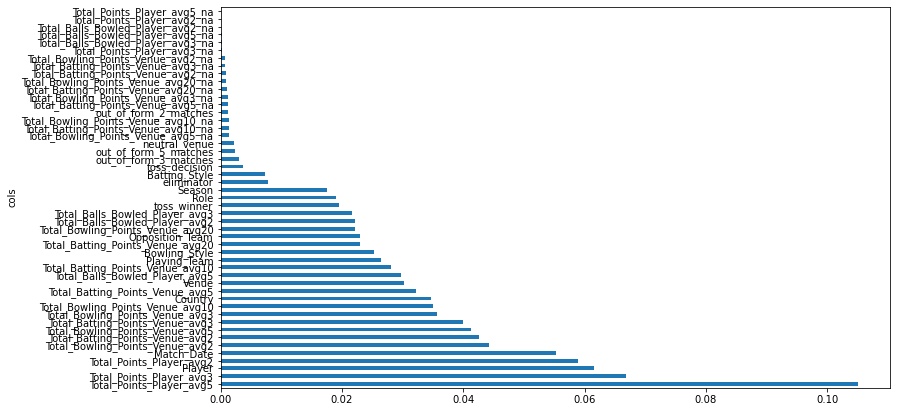

In [345]:
m = RandomForestRegressor(n_jobs=-1, 
                          n_estimators=80,
                          min_samples_leaf=3,
                          max_features=0.7,
                          max_depth=20,
                          min_impurity_decrease=0.01,
                          ccp_alpha=0.7)
%time m.fit(X_train, y_train)
print_score(m)

fi = rf_feat_importance(m, df)
plot_fi(fi[:60]);

In [346]:
to_keep = fi[fi.imp>0.002].cols; len(to_keep)
df_keep = df[to_keep].copy()
#df_keep.drop('Match_Date',axis=1,inplace=True)
X_train, X_valid = split_vals(df_keep, n_trn)

[26.49322616491245, 15.98024682825302, 0.2321254419633514, nan, 0.027402430915861586]


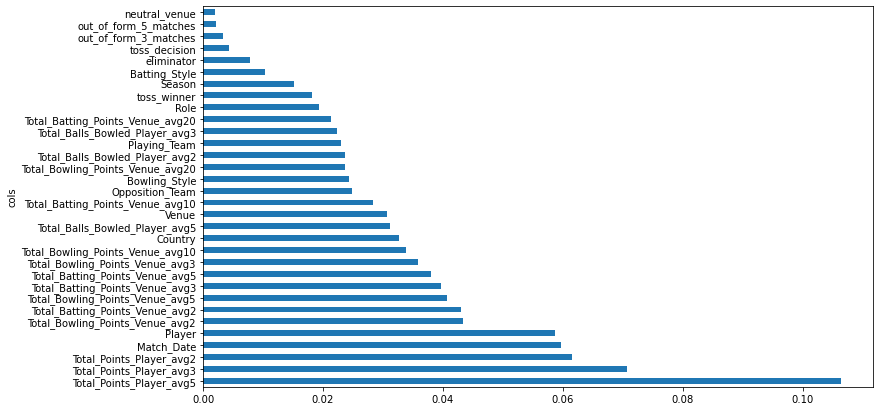

In [347]:
m = RandomForestRegressor(n_jobs=-1, 
                          n_estimators=400,
                          min_samples_leaf=3,
                          max_features=0.7,
                          max_depth=20,
                          min_impurity_decrease=0.01,
                          ccp_alpha=0.7,
                          oob_score=True)
m.fit(X_train, y_train)
print_score(m)
fi = rf_feat_importance(m, df_keep);
plot_fi(fi[:60]);

##### XGBoost

In [157]:
import xgboost as xgb
from xgboost import plot_importance

In [369]:
model = xgb.XGBRegressor(n_estimators = 50, max_depth=50, learning_rate=0.7, subsample=0.5)
xgb_model = model.fit(X_train, y_train)
print_score(xgb_model)

[0.10151995417151662, 2.44693660736084, 0.9999887248219019, nan]


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

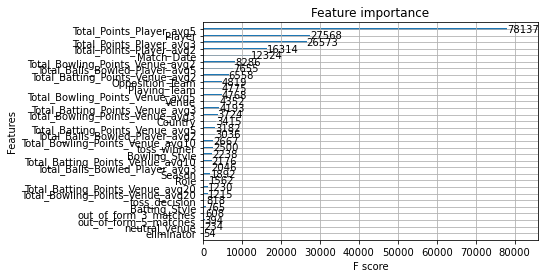

In [370]:
plot_importance(xgb_model)

##### Catboost

In [166]:
from catboost import CatBoostRegressor,Pool

In [371]:
catboost_model = CatBoostRegressor(iterations=25,
                          learning_rate=0.7,
                          l2_leaf_reg=0.1,
                          depth=15,
                         random_strength =1,
                         od_type='IncToDec',
                         random_seed=1)
# Fit model
catboost_model.fit(X_train, y_train)
print_score(model)

0:	learn: 25.2499892	total: 2.09s	remaining: 50.2s
1:	learn: 22.8009020	total: 4.28s	remaining: 49.2s
2:	learn: 20.6888163	total: 6.59s	remaining: 48.3s
3:	learn: 19.3551348	total: 8.71s	remaining: 45.7s
4:	learn: 17.7890808	total: 10.7s	remaining: 42.9s
5:	learn: 17.0627193	total: 12.9s	remaining: 40.9s
6:	learn: 16.0203661	total: 15.1s	remaining: 38.9s
7:	learn: 15.5791981	total: 17.4s	remaining: 36.9s
8:	learn: 14.4058465	total: 19.4s	remaining: 34.6s
9:	learn: 14.1408839	total: 21.6s	remaining: 32.4s
10:	learn: 13.7342608	total: 23.7s	remaining: 30.2s
11:	learn: 12.7799297	total: 25.7s	remaining: 27.9s
12:	learn: 11.9996302	total: 27.9s	remaining: 25.7s
13:	learn: 11.3260711	total: 29.9s	remaining: 23.5s
14:	learn: 10.7100196	total: 31.9s	remaining: 21.3s
15:	learn: 9.9770812	total: 34s	remaining: 19.1s
16:	learn: 9.4537902	total: 35.9s	remaining: 16.9s
17:	learn: 8.8057406	total: 38s	remaining: 14.8s
18:	learn: 8.4031583	total: 40s	remaining: 12.6s
19:	learn: 7.9760530	total: 42.1

In [1386]:
cat_features = [0]
train_dataset = Pool(data=X_train,
                     label=y_train,
                     cat_features=cat_features)
eval_dataset = Pool(data=X_valid,
                    label=y_valid,
                    cat_features=cat_features)

In [1389]:
catboost_model = CatBoostRegressor(iterations=20)
# Fit model
catboost_model.fit(train_dataset, use_best_model=True,
          eval_set=eval_dataset)
print_score(catboost_model)

Learning rate set to 0.5
0:	learn: 29.9599904	test: 33.7437806	best: 33.7437806 (0)	total: 37.3ms	remaining: 708ms
1:	learn: 29.8865442	test: 33.5296706	best: 33.5296706 (1)	total: 75.4ms	remaining: 678ms
2:	learn: 29.8089630	test: 33.5296993	best: 33.5296706 (1)	total: 108ms	remaining: 612ms
3:	learn: 29.7470110	test: 32.5925975	best: 32.5925975 (3)	total: 142ms	remaining: 569ms
4:	learn: 29.7248140	test: 32.6375336	best: 32.5925975 (3)	total: 177ms	remaining: 531ms
5:	learn: 29.6697131	test: 32.7131140	best: 32.5925975 (3)	total: 219ms	remaining: 510ms
6:	learn: 29.6330936	test: 32.5393690	best: 32.5393690 (6)	total: 257ms	remaining: 478ms
7:	learn: 29.5682894	test: 32.8887553	best: 32.5393690 (6)	total: 292ms	remaining: 438ms
8:	learn: 29.5005628	test: 32.8821085	best: 32.5393690 (6)	total: 333ms	remaining: 406ms
9:	learn: 29.4632292	test: 32.3395144	best: 32.3395144 (9)	total: 374ms	remaining: 374ms
10:	learn: 29.4386258	test: 32.5981528	best: 32.3395144 (9)	total: 419ms	remaining:

### Fetch Today's Match Data

In [394]:
#eventid = 1254070 #Match 13 - Tuesday Apr 20th - DC vs MI
eventid = 1254075
homeTeam = ""
awayTeam = ""
venue = ""
toss = ""
homeTeam_squad = pd.DataFrame(columns = ['playername','iscaptain', 'position', 'profilelink', 'teamname'])
awayTeam_squad = pd.DataFrame(columns = ['playername','iscaptain', 'position', 'profilelink', 'teamname'])
homeTeam_squad_all = pd.DataFrame()
awayTeam_squad_all = pd.DataFrame()

In [395]:
def get_playing_xi(eventid,homeTeam_squad,awayTeam_squad):
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/56.0.2924.76 Safari/537.36',
        "Upgrade-Insecure-Requests": "1", "DNT": "1",
        "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8", "Accept-Language": "en-US,en;q=0.5",
        "Accept-Encoding": "gzip, deflate"}
    
    URL= "https://hsapi.espncricinfo.com/v1/pages/match/home?lang=en&leagueId=8048&eventId="+str(eventid)+"&liveTest=false&qaTest=false"
    response = requests.get(URL, headers=headers)
    data = json.loads(response.text)

    homeTeam = data["meta"]["homeTeamAbbr"]
    homeTeamFullName = data["meta"]["homeTeamName"]
    awayTeam = data["meta"]["awayTeamAbbr"]
    awayTeamFullName = data["meta"]["awayTeamName"]
    venue = data['content']['about']['venue']['text']
    
    if data["header"]["matchStatus"] == "pre":
        oddsHomeTeam = data["meta"]["odds"]["general"][0]["homeTeamOdds"]["odds"]["summary"]
        oddsAwayTeam = data["meta"]["odds"]["general"][0]["awayTeamOdds"]["odds"]["summary"]
        
        df_headToHead = pd.DataFrame(data['content']['headToHead']["events"])
        df_headToHead = df_headToHead.drop(['leagueName','href'],axis=1)
        df_headToHead.columns = ['Result',homeTeam,awayTeam,"Date"]
        df_headToHead['Result'] = homeTeam + " " + df_headToHead['Result'] + " " + awayTeam
    else:
        oddsHomeTeam = "NA"
        oddsAwayTeam = "NA"
        df_headToHead = pd.DataFrame(columns = ['Result',homeTeam,awayTeam,"Date"])
 
    if data['header']['tossDone']:
        toss = data['content']['about']['toss']
        
        for team in data['content']['squads']:
            for playerlist in team['players']:
                dict ={}
                playername = playerlist['name']
                iscaptain = playerlist['isCaptain']
                position = playerlist['position']
                profilelink = playerlist['link']['href']
                teamname = team['teamName']
                dict =  {'playername':playername, 'iscaptain': iscaptain, 'position': position,'profilelink':profilelink,'teamname':teamname}
                if team['teamName'] == homeTeam:
                    homeTeam_squad = homeTeam_squad.append(dict,ignore_index= True)
                elif team['teamName'] == awayTeam:
                    awayTeam_squad = awayTeam_squad.append(dict,ignore_index = True)

        homeTeam_squad.drop_duplicates(subset=None, keep='first', inplace=True)
        awayTeam_squad.drop_duplicates(subset=None, keep='first', inplace=True)
        if homeTeam_squad.shape[0] == 0:
            homeTeam_squad_all = df_squads[df_squads['teamname'] == homeTeamFullName]
            awayTeam_squad_all = df_squads[df_squads['teamname'] == awayTeamFullName]
            playing_squad = pd.concat([homeTeam_squad_all,awayTeam_squad_all])[['playername','teamname']].reset_index().drop('index',axis=1)
        else:
            playing_squad = pd.concat([homeTeam_squad,awayTeam_squad])[['playername','teamname']].reset_index().drop('index',axis=1)
    else:
        toss = "Not done"
        homeTeam_squad_all = df_squads[df_squads['teamname'] == homeTeamFullName]
        awayTeam_squad_all = df_squads[df_squads['teamname'] == awayTeamFullName]
        playing_squad = pd.concat([homeTeam_squad_all,awayTeam_squad_all])[['playername','teamname']].reset_index().drop('index',axis=1)
    
    
    return homeTeam,homeTeamFullName,awayTeam,awayTeamFullName,venue,toss,oddsHomeTeam,oddsAwayTeam,homeTeam_squad,awayTeam_squad,playing_squad,df_headToHead

In [396]:
def get_all_squad(eventid,homeTeam_squad,awayTeam_squad):
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/56.0.2924.76 Safari/537.36',
        "Upgrade-Insecure-Requests": "1", "DNT": "1",
        "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8", "Accept-Language": "en-US,en;q=0.5",
        "Accept-Encoding": "gzip, deflate"}
    
    URL= "https://hsapi.espncricinfo.com/v1/pages/match/home?lang=en&leagueId=8048&eventId="+str(eventid)+"&liveTest=false&qaTest=false"
    response = requests.get(URL, headers=headers)
    data = json.loads(response.text)

    homeTeam = data["meta"]["homeTeamAbbr"]
    homeTeamFullName = data["meta"]["homeTeamName"]
    awayTeam = data["meta"]["awayTeamAbbr"]
    awayTeamFullName = data["meta"]["awayTeamName"]
    venue = data['content']['about']['venue']['text']
    
    if data["header"]["matchStatus"] == "pre":
        oddsHomeTeam = data["meta"]["odds"]["general"][0]["homeTeamOdds"]["odds"]["summary"]
        oddsAwayTeam = data["meta"]["odds"]["general"][0]["awayTeamOdds"]["odds"]["summary"]
        
        df_headToHead = pd.DataFrame(data['content']['headToHead']["events"])
        df_headToHead = df_headToHead.drop(['leagueName','href'],axis=1)
        df_headToHead.columns = ['Result',homeTeam,awayTeam,"Date"]
        df_headToHead['Result'] = homeTeam + " " + df_headToHead['Result'] + " " + awayTeam
    else:
        oddsHomeTeam = "NA"
        oddsAwayTeam = "NA"
        df_headToHead = pd.DataFrame(columns = ['Result',homeTeam,awayTeam,"Date"])
 

    toss = "Not done"
    homeTeam_squad_all = df_squads[df_squads['teamname'] == homeTeamFullName]
    awayTeam_squad_all = df_squads[df_squads['teamname'] == awayTeamFullName]
    playing_squad = pd.concat([homeTeam_squad_all,awayTeam_squad_all])[['playername','teamname']].reset_index().drop('index',axis=1)


    return homeTeam,homeTeamFullName,awayTeam,awayTeamFullName,venue,toss,oddsHomeTeam,oddsAwayTeam,homeTeam_squad_all,awayTeam_squad_all,playing_squad,df_headToHead

In [401]:
# Run when the playing 11 has been announced
(homeTeam,
 homeTeamFullName,
 awayTeam,
 awayTeamFullName,
 venue,
 toss,
 oddsHomeTeam,
 oddsAwayTeam,
 homeTeam_squad,
 awayTeam_squad,
 playing_squad,
 df_headToHead) = get_playing_xi(eventid,homeTeam_squad,awayTeam_squad)

In [402]:
playing_squad

,playername,teamname
0,Nitish Rana,KKR
1,Shubman Gill,KKR
2,Rahul Tripathi,KKR
3,Eoin Morgan,KKR
4,Sunil Narine,KKR
5,Dinesh Karthik,KKR
6,Andre Russell,KKR
7,Pat Cummins,KKR
8,Varun Chakravarthy,KKR
9,Shivam Mavi,KKR


In [366]:
# Run when the playing 11 has not been announced
(homeTeam,
 homeTeamFullName,
 awayTeam,
 awayTeamFullName,
 venue,
 toss,
 oddsHomeTeam,
 oddsAwayTeam,
 homeTeam_squad,
 awayTeam_squad,
 playing_squad,
 df_headToHead) = get_all_squad(eventid,homeTeam_squad,awayTeam_squad)

In [403]:
# Get Player Enhanced Data Filtered For Current Playing 11 of Home Team
homeTeam_Player_Data = pd.DataFrame()
awayTeam_Player_Data = pd.DataFrame()

if toss == "Not done":
    for player in homeTeam_squad['playername']:
        df_1 = player_enhanced_data[player_enhanced_data['Player'] == player]
        homeTeam_Player_Data = pd.concat([df_1, homeTeam_Player_Data])

    # Get Player Enhanced Data Filtered For of Away Team
    for player in awayTeam_squad['playername']:
        df_1 = player_enhanced_data[player_enhanced_data['Player'] == player]
        awayTeam_Player_Data = pd.concat([df_1, awayTeam_Player_Data])
else:
    for player in homeTeam_squad['playername']:
        df_1 = player_enhanced_data[player_enhanced_data['Player'] == player]
        homeTeam_Player_Data = pd.concat([df_1, homeTeam_Player_Data])

    # Get Player Enhanced Data Filtered For Current Playing 11 of Away Team
    for player in awayTeam_squad['playername']:
        df_1 = player_enhanced_data[player_enhanced_data['Player'] == player]
        awayTeam_Player_Data = pd.concat([df_1, awayTeam_Player_Data])

### Predict Player Ratings for today's match

In [404]:
PlayingSquad_Player_All_Data = pd.DataFrame()

for player in playing_squad['playername']:
    df_1 = player_enhanced_data[player_enhanced_data['Player'] == player]
    PlayingSquad_Player_All_Data = pd.concat([df_1, PlayingSquad_Player_All_Data])

# Get the player's respective last match data
PlayingSquad_Player_All_Data = PlayingSquad_Player_All_Data.sort_values(['Player','match_id']).drop_duplicates('Player',keep='last').reset_index()
PlayingSquad_Player_Data = PlayingSquad_Player_All_Data[useful_features_for_modeling].copy()
PlayingSquad_Player_Data['Venue'] = venue
PlayingSquad_Player_Data['Season'] = '2021'
PlayingSquad_Player_Data['Match_Date'] = date.today().strftime("%Y-%m-%d")
PlayingSquad_Player_Data['neutral_venue'] = 1
PlayingSquad_Player_Data['toss_winner'] = toss.split(',')[0].rstrip().lstrip()
PlayingSquad_Player_Data['toss_decision'] = toss.split(',')[1].split()[2].rstrip().lstrip()
PlayingSquad_Player_Data['eliminator'] = 'N'
PlayingSquad_Player_Data.loc[PlayingSquad_Player_Data.Playing_Team == homeTeamFullName, "Opposition_Team"] = awayTeamFullName
PlayingSquad_Player_Data.loc[PlayingSquad_Player_Data.Playing_Team == awayTeamFullName, "Opposition_Team"] = homeTeamFullName
PlayingSquad_Player_Data.drop('Total_Points',inplace=True,axis=1)

In [406]:
PlayingSquad_Player_Data

,Season,Match_Date,Playing_Team,Opposition_Team,Role,Venue,Player,neutral_venue,toss_winner,toss_decision,eliminator,Total_Balls_Bowled_Player_avg2,Total_Batting_Points_Venue_avg2,Total_Bowling_Points_Venue_avg2,Total_Points_Player_avg2,Total_Balls_Bowled_Player_avg3,Total_Batting_Points_Venue_avg3,Total_Bowling_Points_Venue_avg3,Total_Points_Player_avg3,Total_Balls_Bowled_Player_avg5,Total_Batting_Points_Venue_avg5,Total_Bowling_Points_Venue_avg5,Total_Points_Player_avg5,Total_Batting_Points_Venue_avg10,Total_Bowling_Points_Venue_avg10,Total_Batting_Points_Venue_avg20,Total_Bowling_Points_Venue_avg20,out_of_form_2_matches,out_of_form_3_matches,out_of_form_5_matches,Country,Batting_Style,Bowling_Style
0,2021,2021-04-24,Kolkata Knight Riders,Rajasthan Royals,AllRounder,"Wankhede Stadium, Mumbai",Andre Russell,1,Rajasthan Royals,field,N,16.0,369.5,206.5,26.0,20.000000,NaN,NaN,30.333333,14.4,NaN,NaN,27.6,NaN,NaN,NaN,NaN,0,0,0,Jamaica,Right-hand bat,Right-arm fast
1,2021,2021-04-24,Rajasthan Royals,Kolkata Knight Riders,Bowler,"Wankhede Stadium, Mumbai",Chetan Sakariya,1,Rajasthan Royals,field,N,NaN,493.0,179.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN
2,2021,2021-04-24,Rajasthan Royals,Kolkata Knight Riders,Bowler,"Wankhede Stadium, Mumbai",Chris Morris,1,Rajasthan Royals,field,N,24.0,493.0,179.0,36.5,24.000000,NaN,NaN,42.333333,24.6,NaN,NaN,48.0,NaN,NaN,NaN,NaN,0,0,0,South Africa,Right-hand bat,Right-arm fast-medium
3,2021,2021-04-24,Rajasthan Royals,Kolkata Knight Riders,Batsmen,"Wankhede Stadium, Mumbai",David Miller,1,Rajasthan Royals,field,N,0.0,493.0,179.0,19.0,0.000000,NaN,NaN,15.333333,0.0,NaN,NaN,20.0,NaN,NaN,NaN,NaN,0,0,0,South Africa,Left-hand bat,Off-break
4,2021,2021-04-24,Kolkata Knight Riders,Rajasthan Royals,Batsmen,"Wankhede Stadium, Mumbai",Dinesh Karthik,1,Rajasthan Royals,field,N,0.0,369.5,206.5,12.0,0.000000,NaN,NaN,8.333333,0.0,NaN,NaN,9.4,NaN,NaN,NaN,NaN,0,1,1,India,Right-hand bat,Off-break
5,2021,2021-04-24,Kolkata Knight Riders,Rajasthan Royals,Batsmen,"Wankhede Stadium, Mumbai",Eoin Morgan,1,Rajasthan Royals,field,N,0.0,369.5,206.5,25.5,0.000000,NaN,NaN,20.000000,0.0,NaN,NaN,34.0,NaN,NaN,NaN,NaN,0,1,0,Ireland,Left-hand bat,Right-arm medium
6,2021,2021-04-24,Rajasthan Royals,Kolkata Knight Riders,Bowler,"Wankhede Stadium, Mumbai",Jaydev Unadkat,1,Rajasthan Royals,field,N,19.0,493.0,179.0,21.0,21.000000,NaN,NaN,12.000000,21.2,NaN,NaN,11.4,NaN,NaN,NaN,NaN,0,0,0,India,Right-hand bat,Left-arm fast-medium
7,2021,2021-04-24,Rajasthan Royals,Kolkata Knight Riders,Batsmen,"Wankhede Stadium, Mumbai",Jos Buttler,1,Rajasthan Royals,field,N,0.0,493.0,179.0,28.5,0.000000,NaN,NaN,28.000000,0.0,NaN,NaN,42.8,NaN,NaN,NaN,NaN,0,0,0,England,Right-hand bat,NaN
8,2021,2021-04-24,Rajasthan Royals,Kolkata Knight Riders,Bowler,"Wankhede Stadium, Mumbai",Mustafizur Rahman,1,Rajasthan Royals,field,N,26.0,493.0,179.0,-3.0,24.666667,NaN,NaN,8.000000,24.8,NaN,NaN,8.6,NaN,NaN,NaN,NaN,1,1,1,Bangladesh,Left-hand bat,Left-arm medium
9,2021,2021-04-24,Kolkata Knight Riders,Rajasthan Royals,Batsmen,"Wankhede Stadium, Mumbai",Nitish Rana,1,Rajasthan Royals,field,N,0.0,369.5,206.5,68.5,0.000000,NaN,NaN,49.000000,1.4,NaN,NaN,50.4,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN


In [405]:
PlayingSquad_Player_Data = PlayingSquad_Player_Data.join(df_personal_male.set_index('Player'), on='Player')

ValueError: columns overlap but no suffix specified: Index(['Country', 'Batting_Style', 'Bowling_Style'], dtype='object')

In [412]:
#add_datepart(PlayingSquad_Player_Data, 'Match_Date')
apply_cats(PlayingSquad_Player_Data,player_predictor_data)
df_test = PlayingSquad_Player_Data.copy().sort_values('Player')
X_test, _, nas = proc_df(df_test, na_dict=nas)
X_test = X_test[to_keep]
#X_test = X_test.drop('Match_Date',axis=1,inplace=True)
df_test['Predicted_Points_RF'] = m.predict(X_test)
df_test['Predicted_Points_XGB'] = xgb_model.predict(X_test)
df_test['Predicted_Points_Cat'] = catboost_model.predict(X_test)
df_test['Predicted_Points'] = (df_test['Predicted_Points_RF'] + df_test['Predicted_Points_XGB'] + df_test['Predicted_Points_Cat'])/3
df_test['Predicted_Points'] =  m.predict(X_test)
Final_Result = df_test[['Player','Role','Playing_Team','Opposition_Team','Venue','Predicted_Points']].copy()
Final_Result['Predicted_Points'] = Final_Result['Predicted_Points'].apply(math.trunc)

<AxesSubplot:ylabel='cols'>

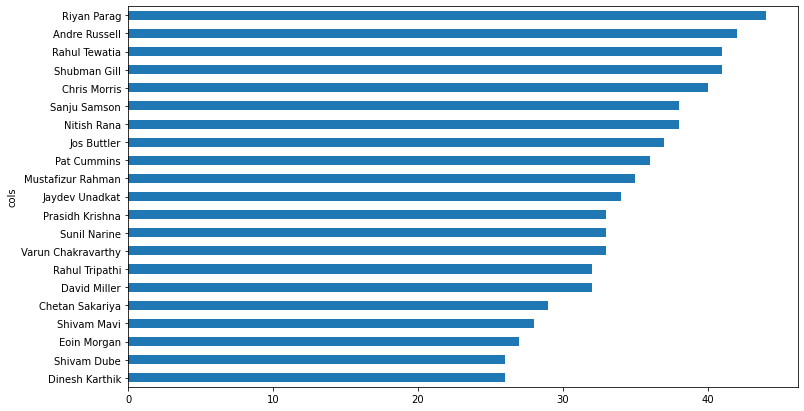

In [413]:
plot_fi(Final_Result[['Player','Predicted_Points']].rename(columns={'Player': 'cols','Predicted_Points':'imp'}).sort_values('imp'))

In [414]:
inFormPlayers = [   'Rohit Sharma',
                    'KL Rahul',
                    'Rahul Chahar',
                    'Chris Gayle',
                    'Trent Boult',
                    'Andre Russell',
                    'Chetan Sakariya',
                    'Dinesh Karthik']

outOfFormPlayers = ['Nicholas Pooran',
                    'Quinton de Kock',
                     'Manan Vohra',
                     'Shreyas Gopal']

In [415]:
for player in Final_Result['Player']:
    if player in inFormPlayers:
        Final_Result.loc[Final_Result.Player == player, "Predicted_Points"] += 15

    if player in outOfFormPlayers:
        Final_Result.loc[Final_Result.Player == player, "Predicted_Points"] -= 15

<AxesSubplot:ylabel='cols'>

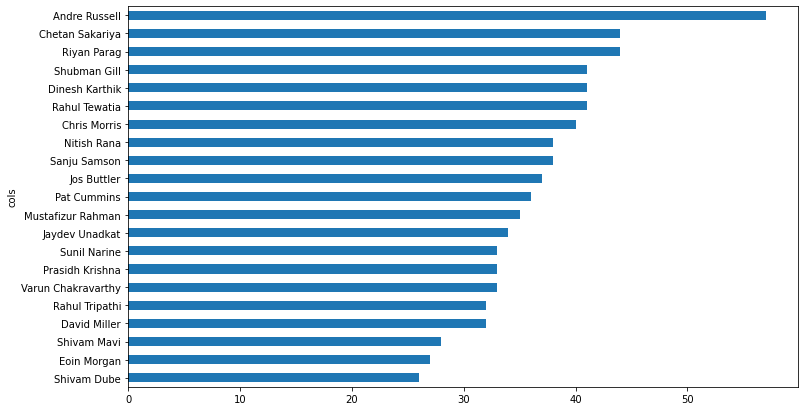

In [416]:
plot_fi(Final_Result[['Player','Predicted_Points']].rename(columns={'Player': 'cols','Predicted_Points':'imp'}).sort_values('imp'))

### Analysis

##### Most runs at the venue

In [1229]:
runs_at_venue_raw = df_raw[['match_id','striker','runs_off_bat','venue','innings']]
runs_at_venue = runs_at_venue_raw.groupby(['match_id','striker','venue','innings']).sum().reset_index()

In [1456]:
runs_at_venue_homeTeam = pd.DataFrame(columns=['Venue','Player','Matches','Runs','Avg','HS'])
for player in homeTeam_squad['playername']:
    runs_at_venue_filter = runs_at_venue[(runs_at_venue['striker'] == player) & (runs_at_venue["venue"] == venue)]
    matches = runs_at_venue_filter['match_id'].count()
    runs = runs_at_venue_filter['runs_off_bat'].sum()
    avg = round(runs/matches,2)
    hs = runs_at_venue_filter['runs_off_bat'].max()
    runs_at_venue_innings_filter = runs_at_venue[(runs_at_venue['striker'] == player) & (runs_at_venue["venue"] == venue) & (runs_at_venue['innings'] == 1)] 
    pct_1st_innings_runs = round(runs_at_venue_innings_filter['runs_off_bat'].sum() * 100/runs, 2)
    
    runs_at_venue_homeTeam = runs_at_venue_homeTeam.append({'Venue':venue,'Player':player,'Matches':matches, 'Runs':runs, 'Avg': avg, 'HS':hs, 'Pct 1st Innings Runs':pct_1st_innings_runs},ignore_index=True)

runs_at_venue_homeTeam = runs_at_venue_homeTeam.sort_values('Runs',ascending=False)
runs_at_venue_homeTeam

NameError: name 'homeTeam_squad_all' is not defined

In [1231]:
runs_at_venue_awayTeam = pd.DataFrame(columns=['Venue','Player','Matches','Runs','Avg','HS'])
for player in awayTeam_squad['playername']:
    runs_at_venue_filter = runs_at_venue[(runs_at_venue['striker'] == player) & (runs_at_venue["venue"] == venue)]
    matches = runs_at_venue_filter['match_id'].count()
    runs = runs_at_venue_filter['runs_off_bat'].sum()
    avg = round(runs/matches,2)
    hs = runs_at_venue_filter['runs_off_bat'].max()
    runs_at_venue_innings_filter = runs_at_venue[(runs_at_venue['striker'] == player) & (runs_at_venue["venue"] == venue) & (runs_at_venue['innings'] == 1)] 
    pct_1st_innings_runs = round(runs_at_venue_innings_filter['runs_off_bat'].sum() * 100/runs, 2)
    
    runs_at_venue_awayTeam = runs_at_venue_awayTeam.append({'Venue':venue,'Player':player,'Matches':matches, 'Runs':runs, 'Avg': avg, 'HS':hs, 'Pct 1st Innings Runs':pct_1st_innings_runs},ignore_index=True)

runs_at_venue_awayTeam = runs_at_venue_awayTeam.sort_values('Runs',ascending=False)
runs_at_venue_awayTeam

,Venue,Player,Matches,Runs,Avg,HS


##### Most runs against the opposition

In [1232]:
runs_against_opposition_raw = df_raw[['match_id','striker','runs_off_bat','bowler']]
runs_against_opposition = runs_against_opposition_raw.groupby(['match_id','striker','bowler']).sum().reset_index()

In [1233]:
runs_by_homeTeam_against_awayTeam = pd.DataFrame(columns=['Player','Against','Matches','Runs','Avg','HS'])
for player in homeTeam_squad['playername']:
    runs_against_opposition_filter = runs_against_opposition[(runs_against_opposition['striker'] == player) & (runs_against_opposition["bowler"].isin(awayTeam_squad['playername'].to_list()))]
    matches = runs_against_opposition_filter['match_id'].count()
    runs = runs_against_opposition_filter['runs_off_bat'].sum()
    avg = round(runs/matches,2)
    hs = runs_against_opposition_filter['runs_off_bat'].max()
    
    runs_by_homeTeam_against_awayTeam = runs_by_homeTeam_against_awayTeam.append({'Player':player,'Against':awayTeam,'Matches':matches, 'Runs':runs, 'Avg': avg, 'HS':hs},ignore_index=True)

runs_by_homeTeam_against_awayTeam = runs_by_homeTeam_against_awayTeam.sort_values('Runs',ascending=False)

In [1234]:
runs_by_awayTeam_against_homeTeam = pd.DataFrame(columns=['Player','Against','Matches','Runs','Avg','HS'])
for player in awayTeam_squad['playername']:
    runs_against_opposition_filter = runs_against_opposition[(runs_against_opposition['striker'] == player) & (runs_against_opposition["bowler"].isin(homeTeam_squad['playername'].to_list()))]
    matches = runs_against_opposition_filter['match_id'].count()
    runs = runs_against_opposition_filter['runs_off_bat'].sum()
    avg = round(runs/matches,2)
    hs = runs_against_opposition_filter['runs_off_bat'].max()
    runs_by_awayTeam_against_homeTeam = runs_by_awayTeam_against_homeTeam.append({'Player':player,'Against':homeTeam,'Matches':matches, 'Runs':runs, 'Avg': avg, 'HS':hs},ignore_index=True)

runs_by_awayTeam_against_homeTeam = runs_by_awayTeam_against_homeTeam.sort_values('Runs',ascending=False)

In [1235]:
runs_by_awayTeam_against_homeTeam

,Player,Against,Matches,Runs,Avg,HS


##### Most wickets at the venue

In [1103]:
bowlers_at_venue_raw = df_raw[['match_id','bowler','ball','wicket_type','venue','innings']]
wickets_at_venue_raw = bowlers_at_venue_raw[bowlers_at_venue_raw['wicket_type'].notnull()]
wickets_at_venue = wickets_at_venue_raw.groupby(['match_id','bowler','venue','ball','innings']).sum().reset_index()

In [1106]:
# Wickets by home team at the venue
wickets_at_venue_homeTeam = pd.DataFrame(columns=['Venue','Bowler','Matches','Wickets'])
for bowler in homeTeam_squad['playername']:
    wickets_at_venue_filter = wickets_at_venue[(wickets_at_venue['bowler'] == bowler) & (wickets_at_venue['venue'] == venue) & (wickets_at_venue['wicket_type'] != 'run out')]
    wickets = wickets_at_venue_filter.shape[0]
    matches = wickets_at_venue_filter['match_id'].unique().size

    #print(wickets_at_venue_grouped)
    wickets_at_venue_homeTeam = wickets_at_venue_homeTeam.append({'Venue':venue,'Bowler':bowler,'Matches':matches, 'Wickets':wickets},ignore_index=True)

wickets_at_venue_homeTeam = wickets_at_venue_homeTeam.sort_values('Wickets',ascending=False)
wickets_at_venue_homeTeam

,Venue,Bowler,Matches,Wickets
8,"Wankhede Stadium, Mumbai",Mohammed Shami,4,8
10,"Wankhede Stadium, Mumbai",Arshdeep Singh,2,4
3,"Wankhede Stadium, Mumbai",Deepak Hooda,1,1
7,"Wankhede Stadium, Mumbai",Jhye Richardson,1,1
9,"Wankhede Stadium, Mumbai",Riley Meredith,1,1
0,"Wankhede Stadium, Mumbai",KL Rahul,0,0
1,"Wankhede Stadium, Mumbai",Mayank Agarwal,0,0
2,"Wankhede Stadium, Mumbai",Chris Gayle,0,0
4,"Wankhede Stadium, Mumbai",Nicholas Pooran,0,0
5,"Wankhede Stadium, Mumbai",Shahrukh Khan,0,0


In [1107]:
# Wickets by away team at the venue
wickets_at_venue_awayTeam = pd.DataFrame(columns=['Venue','Bowler','Matches','Wickets'])
for bowler in awayTeam_squad['playername']:
    wickets_at_venue_filter = wickets_at_venue[(wickets_at_venue['bowler'] == bowler) & (wickets_at_venue['venue'] == venue) & (wickets_at_venue['wicket_type'] != 'run out')]
    wickets = wickets_at_venue_filter.shape[0]
    matches = wickets_at_venue_filter['match_id'].unique().size

    #print(wickets_at_venue_grouped)
    wickets_at_venue_awayTeam = wickets_at_venue_awayTeam.append({'Venue':venue,'Bowler':bowler,'Matches':matches, 'Wickets':wickets},ignore_index=True)

wickets_at_venue_awayTeam = wickets_at_venue_awayTeam.sort_values('Wickets',ascending=False)
wickets_at_venue_awayTeam

,Venue,Bowler,Matches,Wickets
8,"Wankhede Stadium, Mumbai",Ravichandran Ashwin,9,12
7,"Wankhede Stadium, Mumbai",Chris Woakes,4,6
9,"Wankhede Stadium, Mumbai",Kagiso Rabada,3,5
10,"Wankhede Stadium, Mumbai",Avesh Khan,2,5
4,"Wankhede Stadium, Mumbai",Marcus Stoinis,1,1
0,"Wankhede Stadium, Mumbai",Prithvi Shaw,0,0
1,"Wankhede Stadium, Mumbai",Shikhar Dhawan,0,0
2,"Wankhede Stadium, Mumbai",Steven Smith,0,0
3,"Wankhede Stadium, Mumbai",Rishabh Pant,0,0
5,"Wankhede Stadium, Mumbai",Lalit Yadav,0,0


##### Batsmen Points

### Send Email

In [ ]:
def send_email_team(homeTeam,
                    awayTeam,
                    homeTeam_squad,
                    awayTeam_squad,
                    venue,
                    toss,
                    oddsHomeTeam,
                    oddsAwayTeam,
                    df_headToHead,
                    runs_at_venue_homeTeam,
                    runs_at_venue_awayTeam,
                    runs_by_homeTeam_against_awayTeam,
                    runs_by_awayTeam_against_homeTeam,
                    wickets_at_venue_homeTeam,
                    wickets_at_venue_awayTeam,
                    receiver_email):
    todays_date = date.today().strftime("%b-%d-%Y")
    msg = MIMEMultipart()
    msg['Subject'] = "Dream11: " + homeTeam + " vs " + awayTeam + ": " + todays_date
    msg['From'] = 'apaar.sinha@lexisnexisrisk.com'
    msg['To'] = "apaar.sinha@lexisnexisrisk.com"

    html = """\
    <html>
      <head></head>
      <body>
        <h5>Venue: {4}</h5>
        <h5>Home Team: {0}</h5>
        <h5>Away Team: {2}</h5>
        <h5>Bet365 Home Team Odds: {6}</h5>
        <h5>Bet365 Away Team Odds: {7}</h5>
        <h5>Head to Head - Last 5 matches</h>
        {8}
        <h5>Toss: {5}</h5>
        <h5>{0} Squad (Home Team)</h5>
        {1}
        </n>
        <h5>{2} Squad (Away Team)</h5>
        {3}
        </n>
        </n>
        <h5>Most runs at the venue - {0}</h5>
        {9}
        <h5>Most runs at the venue - {2}</h5>
        {10}
        <h5>Most runs by {0} batsmen agains {2} bowlers</h5>
        {11}
        <h5>Most runs by {2} batsmen agains {0} bowlers</h5>
        {12}
        </n>
        </n>
        <h5>Most wickets at the venue - {0}</h5>
        {13}
        <h5>Most wickets at the venue - {2}</h5>
        {14}
      </body>
    </html>
    """.format(homeTeam,homeTeam_squad.to_html(),
               awayTeam,awayTeam_squad.to_html(),
               venue,
               toss,
               oddsHomeTeam,
               oddsAwayTeam,
               df_headToHead.to_html(),
               runs_at_venue_homeTeam.to_html(),
               runs_at_venue_awayTeam.to_html(),
               runs_by_homeTeam_against_awayTeam.to_html(),
               runs_by_awayTeam_against_homeTeam.to_html(),
               wickets_at_venue_homeTeam.to_html(),
               wickets_at_venue_awayTeam.to_html())

    part1 = MIMEText(html, 'html')
    msg.attach(part1)
    
    s = smtplib.SMTP('Appmail-Test.risk.regn.net', 25)
    s.sendmail(msg['From'], msg['To'] , msg.as_string())
    s.quit()

In [ ]:
send_email_team(homeTeam,
                awayTeam,
                homeTeam_squad,
                awayTeam_squad,
                venue,
                toss,
                oddsHomeTeam,
                oddsAwayTeam,
                df_headToHead,
                runs_at_venue_homeTeam,
                runs_at_venue_awayTeam,
                runs_by_homeTeam_against_awayTeam,
                runs_by_awayTeam_against_homeTeam,
                wickets_at_venue_homeTeam,
                wickets_at_venue_awayTeam,
                "apaar.sinha@lexisnexisrisk.com")

### To Do

1. Fetch player cost from Dream11 
2. Clean all players name - done
3. Clean all team names - done
4. Add playing_team, Opposition_team info - done
5. Include data from yaml for toss info 
6. Decide on predictor columns - done
6. Build ML model - done

In [1616]:
venue

'MA Chidambaram Stadium, Chepauk, Chennai'

In [1518]:
player_enhanced_data

,match_id,Player,Total_Runs,Total_Balls_Faced,Total_Legal_Balls_Faced,Sixes,Fours,batsmen_innings,batsmen_battingteam,batsmen_bowlingteam,Wickets,Total_Balls_Bowled,Total_Legal_Balls_Bowled,Total_Number_Of_NoBalls,Total_Runs_Given_On_NoBalls,Total_Number_Of_Wides,Total_Runs_Given_On_Wides,Total_Runs_Conceded_OffBat,Number_of_Maidens,bowler_innings,bowler_battingteam,bowler_bowlingteam,economy_rate,Role,Total_Runs_Points,Sixes_Points,Fours_Points,Runs_Bonus_Points,Total_Batting_Points,Wickets_Points,ER_Points,Maiden_Overs_Points,Wicket_Bonus_Points,Total_Bowling_Points,Total_Points,Season,Match_Date,Venue,Player_Match_Count
0,335982,AA Noffke,9.0,12.0,10.0,NaN,1.0,2.0,Royal Challengers Bangalore,Kolkata Knight Riders,1.0,25.0,24.0,0.0,0.0,1.0,5.0,35.0,0.0,1.0,Kolkata Knight Riders,Royal Challengers Bangalore,10.00,AllRounder,9.0,NaN,1.0,0,10.0,25.0,-4,0.0,0,21.0,31.0,2007/08,2008-04-18,"M.Chinnaswamy Stadium, Bengaluru",1
12422,335982,AB Agarkar,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,28.0,24.0,0.0,0.0,4.0,4.0,21.0,0.0,2.0,Royal Challengers Bangalore,Kolkata Knight Riders,6.25,Bowler,NaN,NaN,NaN,0,NaN,75.0,0,0.0,0,75.0,75.0,2007/08,2008-04-18,"M.Chinnaswamy Stadium, Bengaluru",1
12423,335982,AB Dinda,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,20.0,18.0,0.0,0.0,2.0,2.0,7.0,0.0,2.0,Royal Challengers Bangalore,Kolkata Knight Riders,3.00,Bowler,NaN,NaN,NaN,0,NaN,50.0,6,0.0,0,56.0,56.0,2007/08,2008-04-18,"M.Chinnaswamy Stadium, Bengaluru",1
1,335982,B Akhil,0.0,2.0,2.0,NaN,NaN,2.0,Royal Challengers Bangalore,Kolkata Knight Riders,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bowler,0.0,NaN,NaN,-2,-2.0,NaN,0,NaN,0,NaN,-2.0,2007/08,2008-04-18,"M.Chinnaswamy Stadium, Bengaluru",1
2,335982,BB McCullum,158.0,77.0,71.0,13.0,10.0,1.0,Kolkata Knight Riders,Royal Challengers Bangalore,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Batsmen,158.0,26.0,10.0,24,218.0,NaN,0,NaN,0,NaN,218.0,2007/08,2008-04-18,"M.Chinnaswamy Stadium, Bengaluru",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12418,1254066,Rohit Sharma,32.0,26.0,24.0,2.0,2.0,1.0,Mumbai Indians,Sunrisers Hyderabad,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Batsmen,32.0,4.0,2.0,0,38.0,NaN,0,NaN,0,NaN,38.0,2021,2021-04-17,"MA Chidambaram Stadium, Chepauk, Chennai",199
12419,1254066,Suryakumar Yadav,10.0,6.0,6.0,1.0,1.0,1.0,Mumbai Indians,Sunrisers Hyderabad,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Batsmen,10.0,2.0,1.0,0,13.0,NaN,0,NaN,0,NaN,13.0,2021,2021-04-17,"MA Chidambaram Stadium, Chepauk, Chennai",92
17466,1254066,Trent Boult,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,22.0,22.0,0.0,0.0,0.0,0.0,28.0,0.0,2.0,Sunrisers Hyderabad,Mumbai Indians,7.64,Bowler,NaN,NaN,NaN,0,NaN,75.0,0,0.0,0,75.0,75.0,2021,2021-04-17,"MA Chidambaram Stadium, Chepauk, Chennai",52
12420,1254066,Vijay Shankar,28.0,25.0,24.0,2.0,NaN,2.0,Sunrisers Hyderabad,Mumbai Indians,2.0,18.0,18.0,0.0,0.0,0.0,0.0,19.0,0.0,1.0,Mumbai Indians,Sunrisers Hyderabad,6.33,Batsmen,28.0,4.0,NaN,0,32.0,50.0,0,0.0,0,50.0,82.0,2021,2021-04-17,"MA Chidambaram Stadium, Chepauk, Chennai",40


In [1236]:
homeTeam_Stats_Against_Opposition = homeTeam_Player_Data[(homeTeam_Player_Data['Opposition_Team'] == 'Rajasthan Royals')]
awayTeam_Stats_Against_Opposition = awayTeam_Player_Data[(awayTeam_Player_Data['Opposition_Team'] == 'Chennai Super Kings')]

KeyError: 'Opposition_Team'

In [1122]:
homeTeam_Stats_Against_Opposition.groupby('Player')['Wickets'].sum()

Player
Ambati Rayudu       0.0
Deepak Chahar       9.0
Dwayne Bravo       15.0
Faf du Plessis      0.0
MS Dhoni            0.0
Moeen Ali           0.0
Ravindra Jadeja    16.0
Ruturaj Gaikwad     0.0
Sam Curran          5.0
Shardul Thakur      7.0
Suresh Raina        4.0
Name: Wickets, dtype: float64

In [1127]:
awayTeam_Stats_Against_Opposition.groupby('Player')['Wickets'].sum()

Player
Chris Morris         9.0
David Miller         0.0
Jaydev Unadkat       5.0
Jos Buttler          0.0
Manan Vohra          0.0
Mustafizur Rahman    1.0
Rahul Tewatia        4.0
Riyan Parag          0.0
Sanju Samson         0.0
Shivam Dube          0.0
Name: Wickets, dtype: float64

In [1130]:
homeTeam_Stats_Against_Opposition.groupby('Player')['Total_Runs'].sum()

Player
Ambati Rayudu      344.0
Deepak Chahar        0.0
Dwayne Bravo       195.0
Faf du Plessis     237.0
MS Dhoni           477.0
Moeen Ali           19.0
Ravindra Jadeja    152.0
Ruturaj Gaikwad      0.0
Sam Curran          39.0
Shardul Thakur       0.0
Suresh Raina       609.0
Name: Total_Runs, dtype: float64

In [1131]:
awayTeam_Stats_Against_Opposition.groupby('Player')['Total_Runs'].sum()

Player
Chris Morris          18.0
David Miller         253.0
Jaydev Unadkat        17.0
Jos Buttler          216.0
Manan Vohra           54.0
Mustafizur Rahman      0.0
Rahul Tewatia         24.0
Riyan Parag           22.0
Sanju Samson         153.0
Shivam Dube           24.0
Name: Total_Runs, dtype: float64